<a href="https://colab.research.google.com/github/VinylBr/Supervised_learning_from_scratch/blob/main/Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample $f(x)$ when $x$ is sampled from $p(x)$

$E[f] = ∫f(x)\times p(x)dx$
<br>
<br>
Goal → $E[f]$ <br>


1. Sampling from standard distributions (Box-Muller) is used to sample from $p(x)$
2. Rejection sampling is used to sample from $p(x)$
3. Importance sampling directly gives me $E[f]$
4. Markov-Chain Monte Carlo simulations allows sampling from a difficult to sample $p(x)$

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# Box-Muller Sampling
---
Aim: To obtain independently sampled (I.I.D) normal distribution from a source of uniformly distribution <br>

**Algorithm**: <br>
1. Get $CDF^{-1}$ of a target distribution
2. Sample $x$ from uniform distribution
3. $CDF^{-1}(x)$ is the target distribution
<br>

In Box-muller sampling,
1. we generate a 2-D uniform distribution with $p(x_1, x_2) = 1/π$
2. Convert to polar coordinates with theta ϵ $[0, 2π]$
3. R = $-\sqrt{2×log(x_1)}$, this is the $CDF^{-1}$
4. Generate samples $y_1 = R×cos(theta)$ and $y_2 = R×sin(theta)$





In [ ]:
class boxmuller2D:
  """
  To sample from indendent normal distribution

  attributes:
  mean: Expectated value of the normal distributions
  std: standard deviation of the normal distributions

  return Y1, Y2 that are normally distributed with mean and variance (std^2)
  """
  def __init__(self, mean = 0, std = 1):
    self.mean = mean
    self.std = std

  def sample(self, n):
    U = np.random.rand(2,n) #2-D distribution
    R = np.sqrt(-2*np.log(U[1,:])) #converting to polar coordinates, R
    theta = 2*np.pi*U[0,:]#theta in polar coordinates
    Y1, Y2 = R*np.cos(theta), R*np.sin(theta) #for different mean and variance (std^2)
    Y1 = Y1*self.std + self.mean
    Y2 = Y2*self.std + self.mean
    return Y1, Y2

  def __repr__(self):
    return f"boxmuller2D{self.mean, self.std}"


In [ ]:
b1 = boxmuller2D()
print(f"Class name: {b1}")
Y1, Y2 = b1.sample(n = 1000)

Class name: boxmuller2D(0, 1)


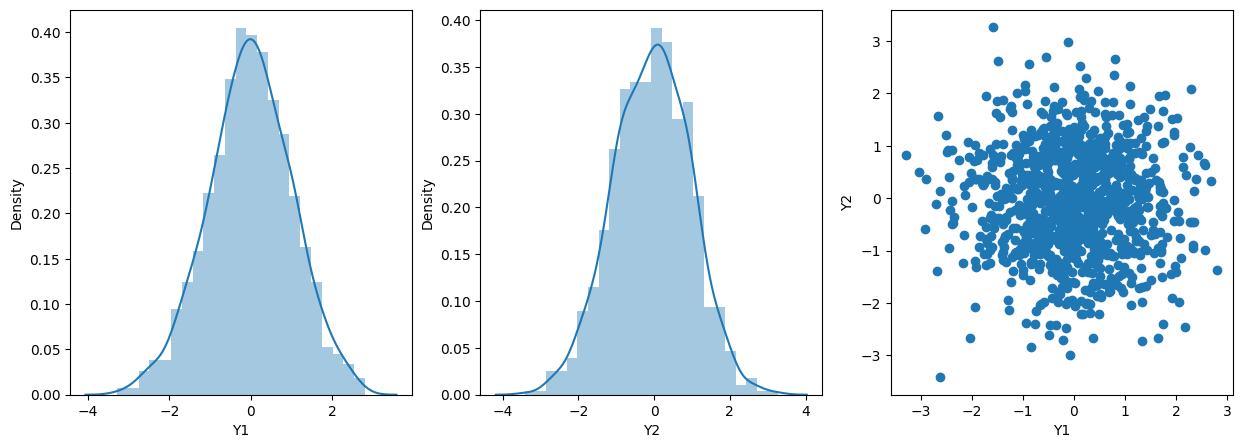

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.distplot(Y1, ax = ax[0])
ax[0].set_xlabel("Y1")
sns.distplot(Y2, ax = ax[1])
ax[1].set_xlabel("Y2")
ax[2].scatter(Y1, Y2)
ax[2].set_xlabel("Y1")
ax[2].set_ylabel("Y2")
plt.show()

# Rejection Sampling <br>


---


Inspiration: https://jaketae.github.io/study/rejection-sampling/ <br>

**Algorithm**: <br>
1. Sample $x$ from the proposal distribution ($q(x)$) <br>
2. Sample $c$ from a uniform distribution <br>
3. If $\frac{p(x)}{k\times q(x)}$ > $c$ <br>
    ignore sample <br>
4. repeat while n < size

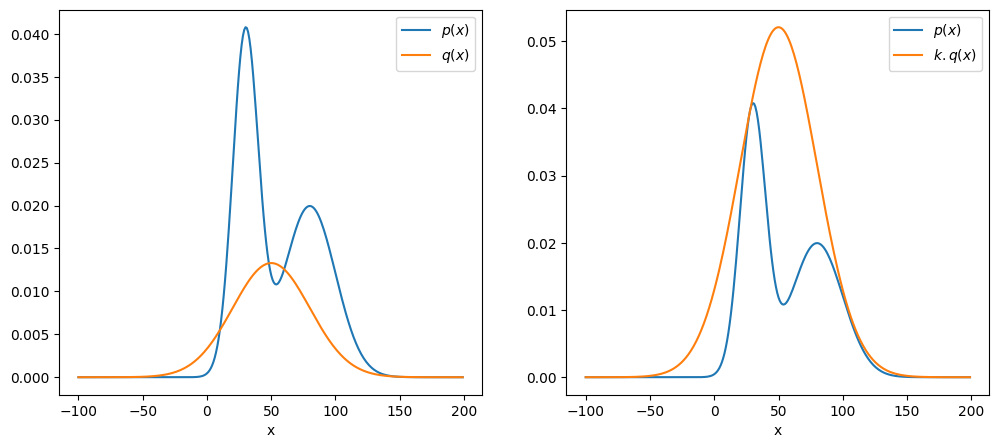

In [ ]:
def p(x):
  return norm.pdf(x, loc = 30, scale = 10) + norm.pdf(x, loc = 80, scale = 20)

def q(x, loc = 50, scale = 30):
  return norm.pdf(x, loc = loc, scale = scale)

x = np.arange(-100, 200)
k = max(p(x)/q(x))

fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(x, p(x), label = r"$p(x)$")
ax[0].plot(x, q(x), label = r"$q(x)$")
ax[1].plot(x, p(x), label = r"$p(x)$")
ax[1].plot(x, k*q(x), label = r"$k.q(x)$")
for a in ax:
  a.set_xlabel("x")
  a.legend()
plt.show()

In [ ]:
def rejection_sample(size):
  xsample = np.random.normal(50, 30, size = size)
  csample = np.random.uniform(0, 1, size = size)
  mask = p(xsample)/(k * q(xsample)) > csample
  return xsample[mask]

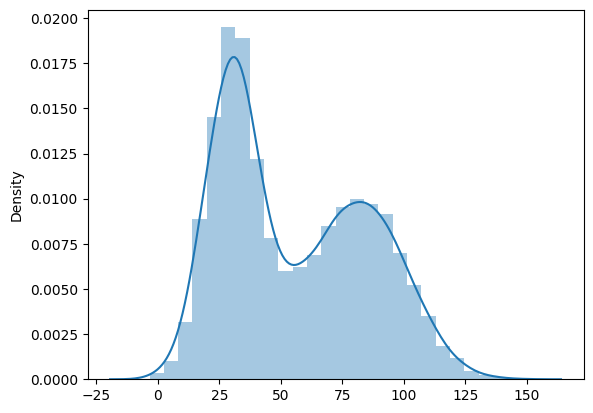

In [ ]:
samples = rejection_sample(10000)
sns.distplot(samples)
plt.show()

#Importance Sampling#
---


Directly calculates Expectation of $f$ without giving a sampling mechanism from $p(x)$ <br>
Usually when $p(x)$ is impossible to sample from <br>
Inspiration: https://medium.com/@amir_masoud/a-simple-tutorial-on-sampling-importance-and-monte-carlo-with-python-codes-8ce809b91465
<br>

$$E[f] = \frac{1}{N} \sum_{1}^{N} \frac{p(x_i)}{q(x_i)} f(x_i)$$
where, $x_i$ is sampled from $q(x_i)$

In [ ]:
def f(x): #sigmoid
  return 1/(1 + np.exp(-x))
p_mean, q_mean = 3.5, 3
p_std, q_std = 1, 1
p = norm(loc = p_mean, scale = p_std)
q = norm(loc = q_mean, scale = q_std)

In [ ]:
def E_f(p,q,size):
  """
  p: difficult to sample distribution
  q: easy to sample distribution
  size: number of samples
  """
  x_i = q.rvs(size)
  weights = p.pdf(x_i)/q.pdf(x_i)
  E = sum(f(x_i)*weights)/size

  return E

In [ ]:
size = 1000
f_ref = E_f(p,p,size) #if sampled from itself. weights = 1 (used as reference)
f_test = E_f(p,q,size) #if sampled from an easier to sample, q

In [ ]:
print(f_ref, f_test)

0.9570042568933264 0.9403968291591459


# Markov-Chain Monte Carlo Sampling
---
Aim: Get samples from a distribution $p(x)$
**Algorithm**: <br>
1. generate x ∼ $q(x/x_t)$, here $q$ = 𝒩($x_t$, $σ^2$ = width) and $x_t$ is current value
2. accept x with probability = $min(1, \frac{p(x)q(x_t/x)}{p(x^t)q(x/x_t})$, implemented with ∼𝓤(0,1)
3. if accepted update $x_t$ else append $x_{t-1}$

In [9]:
class MCMCSampler:
  """
  Produce Markov-Chain Monte Carlo Sampling

  attributes:
  samples = number of samples
  mu = initial guess for mean
  width = local normal distribution's variance
  """
  def __init__(self, samples = 100, mu = 0.5, width = 0.5):
    self.samples = samples
    self.mu_current = mu
    self.width = width

  def sample(self, data, mu_prior, sd_prior, sigma):
    posterior = [self.mu_current]
    for i in range(self.samples):
      #---------------------------------------#
      #            Taking a step              #
      #---------------------------------------#

      mu_proposal = norm(self.mu_current, self.width).rvs()

      #---------------------------------------#
      #   Calculate likelihood and prior      #
      #---------------------------------------#
      likelihood_t_1 = np.prod(norm(self.mu_current,sigma).pdf(data))
      likelihood_t = np.prod(norm(mu_proposal,sigma).pdf(data))

      prior_t_1 = norm(mu_prior, sd_prior).pdf(self.mu_current)
      prior_t = norm(mu_prior, sd_prior).pdf(mu_proposal)

      p_t_1 = likelihood_t_1 * prior_t_1
      p_t = likelihood_t * prior_t

      #---------------------------------------#
      #        Acceptance Criteria            #
      #---------------------------------------#
      accept = p_t/p_t_1 > np.random.rand()

      if accept:
        self.mu_current = mu_proposal
      posterior.append(self.mu_current)



    return np.array(posterior)





In [13]:
MCMC_test = MCMCSampler(samples = 15000)
data = np.random.randn(20)
posterior = MCMC_test.sample(data = data, mu_prior = 0, sd_prior = 1, sigma = 1)

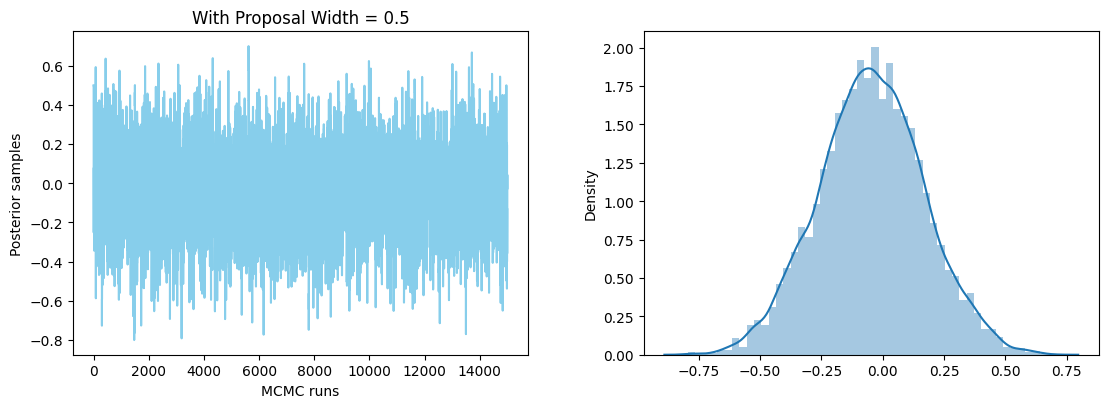

In [14]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(posterior, color = "skyblue")
ax[0].set_xlabel("MCMC runs")
ax[0].set_ylabel("Posterior samples")
ax[0].set_title("With Proposal Width = 0.5")

burnin_runs = 2000
sns.distplot(posterior[burnin_runs:], ax = ax[1])
fig.tight_layout(pad = 4)
plt.show()

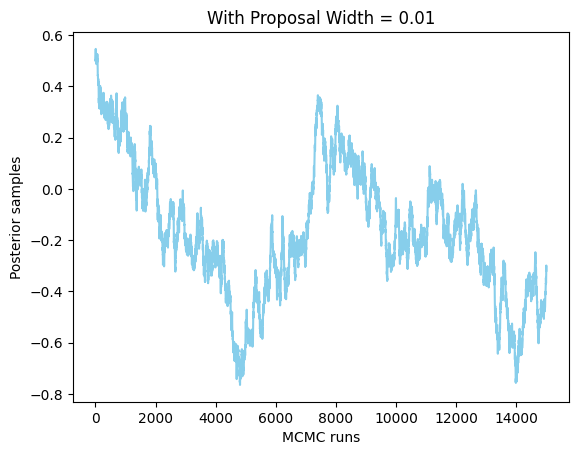

In [11]:
MCMC_test_lower_width = MCMCSampler(samples = 15000, width = 0.01)
posterior_lower_width = MCMC_test.sample(data = data, mu_prior = 0, sd_prior = 1, sigma = 1)
plt.plot(posterior, color = "skyblue")
plt.xlabel("MCMC runs")
plt.ylabel("Posterior samples")
plt.title("With Proposal Width = 0.01")
plt.show()

**OBSERVATAION**: <br>
The proposal width of the local normal distribution becomes important to hae a good MCMC run. <br>
Initial 1000-2000 (ballpark) runs are usually the burn-in period to let the sampler forget the initial values of parameters.